- Check for Colab Env
> if we are in colab env we need to get the data + scripts from github or somewhere

In [1]:
import os
if "COLAB_GPU" in os.environ:
    os.system("git clone https://github.com/zaxo7/UNet-Playground.git")
    os.chdir("/content/UNet-Playground/")


if "PAPERSPACE_FQDN" in os.environ:
    !apt update
    !apt install libgl1 -y
    !pip install opencv-python
    !git pull

Get:1 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:2 http://archive.ubuntu.com/ubuntu focal InRelease                         
Get:3 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]        
Get:4 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:5 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [1816 kB]
Get:6 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1161 kB]
Get:7 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 Packages [27.5 kB]
Get:8 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [874 kB]m
Get:9 http://archive.ubuntu.com/ubuntu focal-updates/restricted amd64 Packages [1252 kB]
Get:10 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [1174 kB]
Get:11 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [2245 kB]
Get:12 http://archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 Pack

- enable module autoreload and fix an import bug

In [2]:
%load_ext autoreload
%autoreload 2

import sys,os
sys.path.append(os.getcwd() + '/scripts')

- import the scripts and data

In [3]:
from scripts import data, model
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2

- load the dataset

In [8]:
train_img_files = glob.glob('data/train/*.jpg')
test_img_files = glob.glob('data/test/*.jpg')

imgs_orig = data.load_image_list(test_img_files)

test_img_chips, test_mask_chips, test_edge_chips = model.generate_test_dataset(test_img_files)

imgs, mask, edge = data.load_data(train_img_files, padding=0)

real_images = ['img1.jpg', 'img2.jpg']

real_images = data.load_data_na(real_images, RGB=True, clahe=True)

# print(f"mask :  {mask[0].shape}")
# print(f"edge :  {edge[0].shape}")
# print(f"img :  {imgs[0].shape}")

saveImages = False

if saveImages:
    for i in np.arange(len(mask)):
        cv2.imwrite(f"data/train/mask/{train_img_files[i].split('/')[2]}", mask[i] * 255.0)
        cv2.imwrite(f"data/train/edge/{train_img_files[i].split('/')[2]}", edge[i] * 255.0)
        
    
imgs, mask, edge = data.load_data(test_img_files, padding=0)

# print(f"mask :  {mask[0].shape}")
# print(f"edge :  {edge[0].shape}")
# print(f"img :  {imgs[0].shape}")

if saveImages:
    for i in np.arange(len(mask)):
        cv2.imwrite(f"data/test/mask/{test_img_files[i].split('/')[2]}", mask[i] * 255.0)
        cv2.imwrite(f"data/test/edge/{test_img_files[i].split('/')[2]}", edge[i] * 255.0)


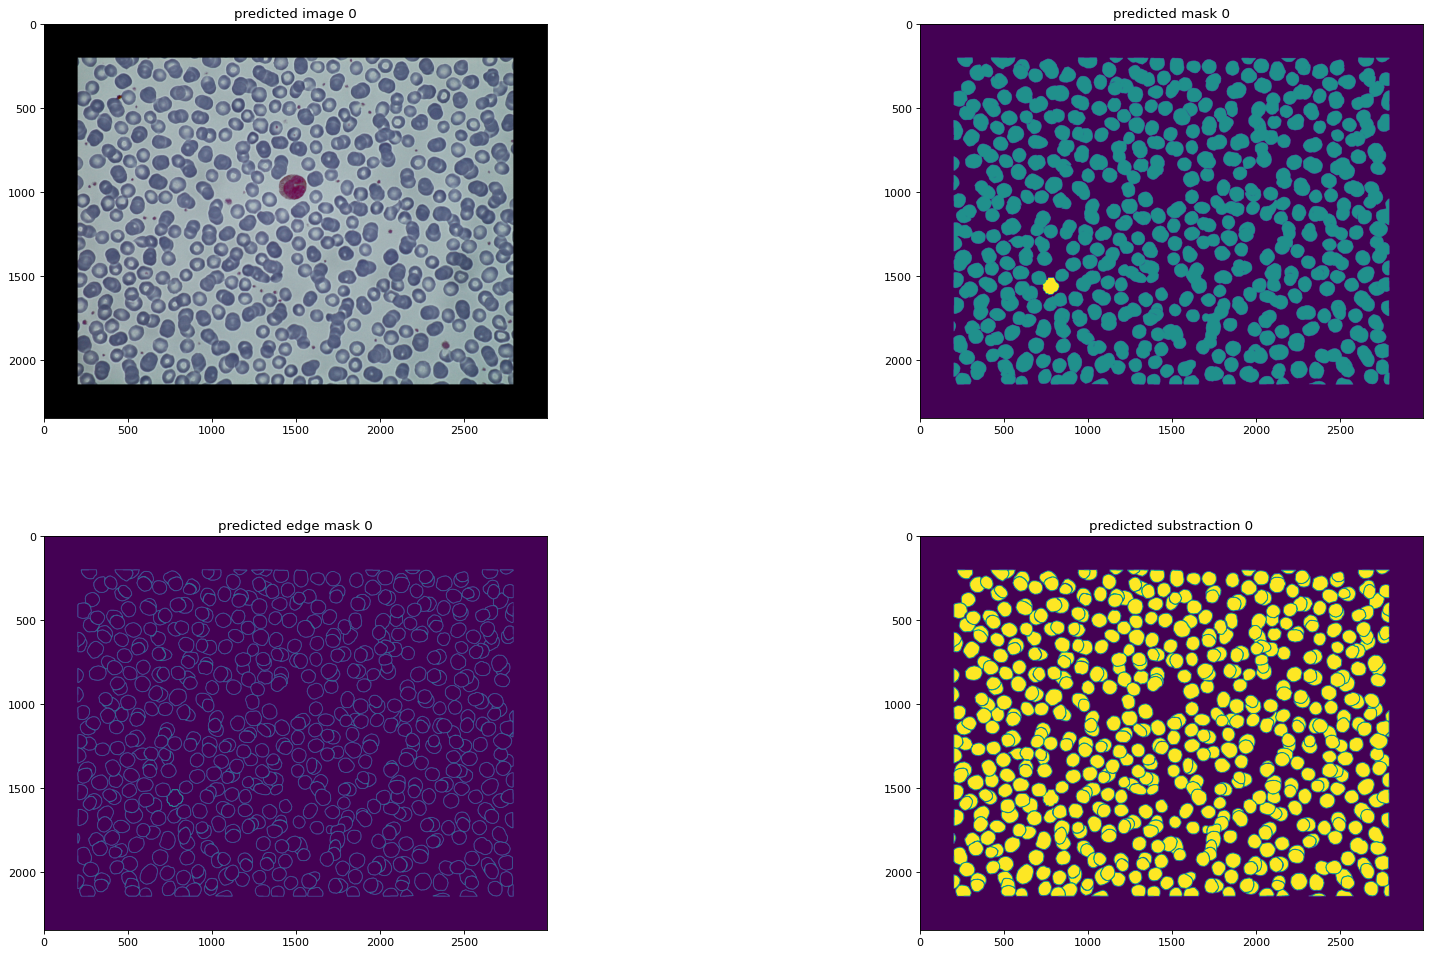

In [10]:
data.plot_ime(imgs,
              mask,
              edge,
              figSize=(25,15),
              max_plots = 3)

- create the model and compile it

In [21]:
unet = model.get_do_unet()
unet1 = model.get_do_unet()
unet2 = model.get_do_unet()

- load weights

In [22]:
_model_name = 'tversky_100'
_model_name1 = 'tversky_100_data2_data_freeze_edge_adv'
_model_name2 = 'tversky_100_data2_data_07_03_adv'

unet.load_weights(f"models/{_model_name}_best.h5")
unet1.load_weights(f"models/{_model_name1}_best.h5")
unet2.load_weights(f"models/{_model_name2}_best.h5")

- check model accuracy

In [ ]:
test_results = unet.evaluate(test_img_chips, (test_mask_chips, test_edge_chips), verbose=1)

In [10]:
#save the evaluation results into a file
import json
with open(f"models/{_model_name}_evaluation_results.json", "w") as fp:
    json.dump(test_results,fp)

# Opening JSON file
with open(f"models/{_model_name}_evaluation_results.json") as fp:

  test_results = json.load(fp)

- calculate mask for image

In [24]:
images, masks, edges = model.predictFullImage(unet,
                          imgs,
                        padding=100,
                        input_size=188,
                        output_size=100,
                        normalize_output = False)


images1, masks1, edges1 = model.predictFullImage(unet1,
                          imgs,
                        padding=100,
                        input_size=188,
                        output_size=100,
                        normalize_output = False)


images2, masks2, edges2 = model.predictFullImage(unet2,
                          imgs,
                        padding=100,
                        input_size=188,
                        output_size=100,
                        normalize_output = False)


- plot the results

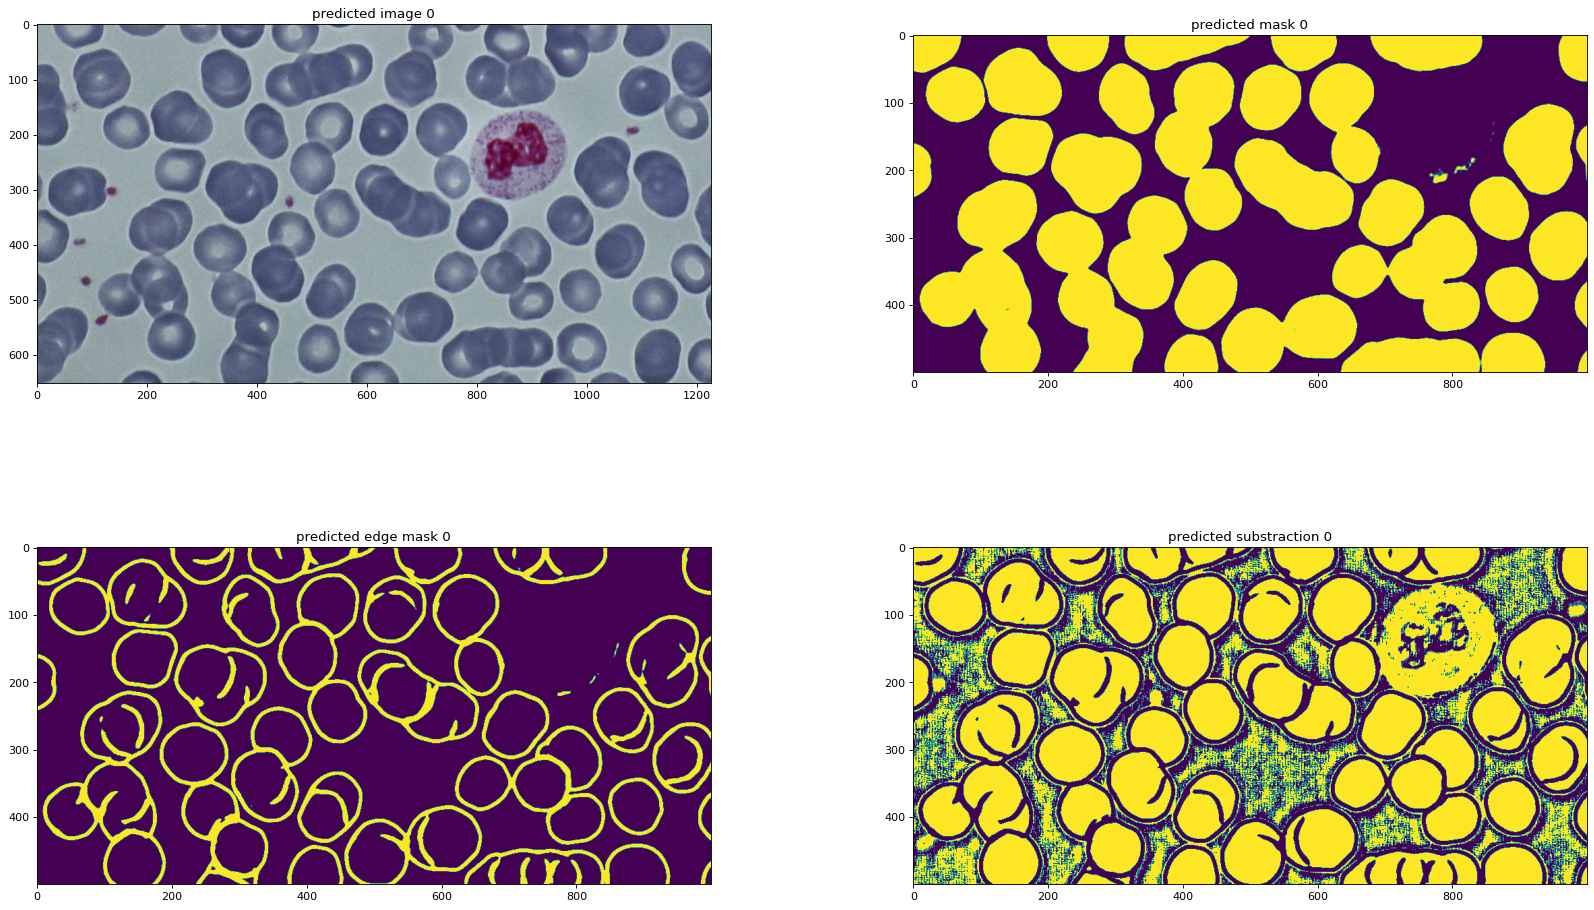

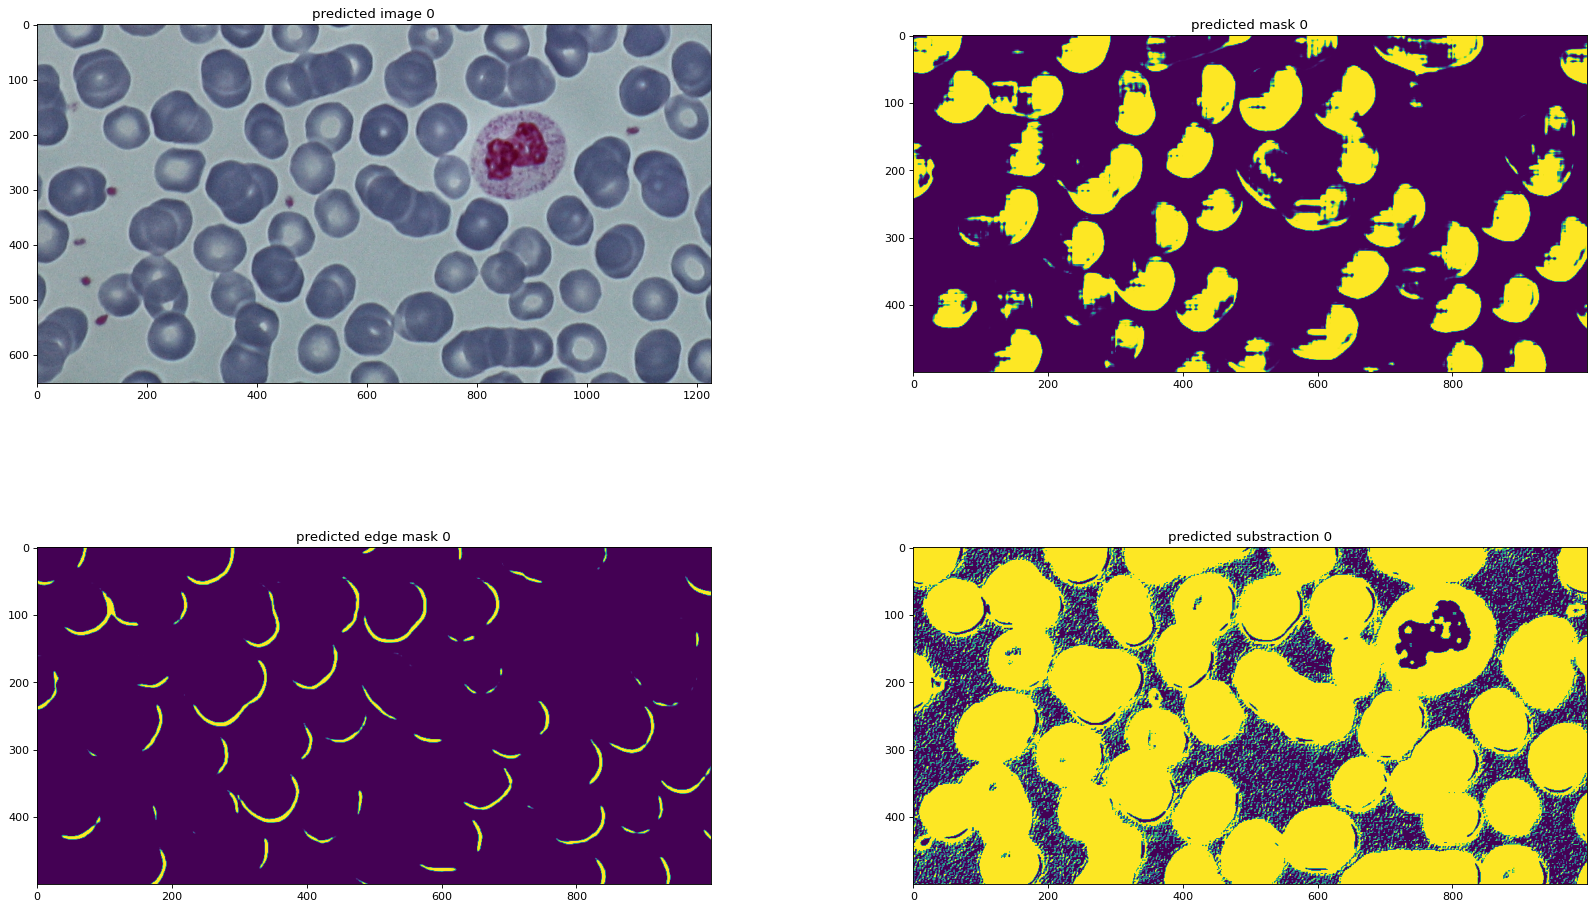

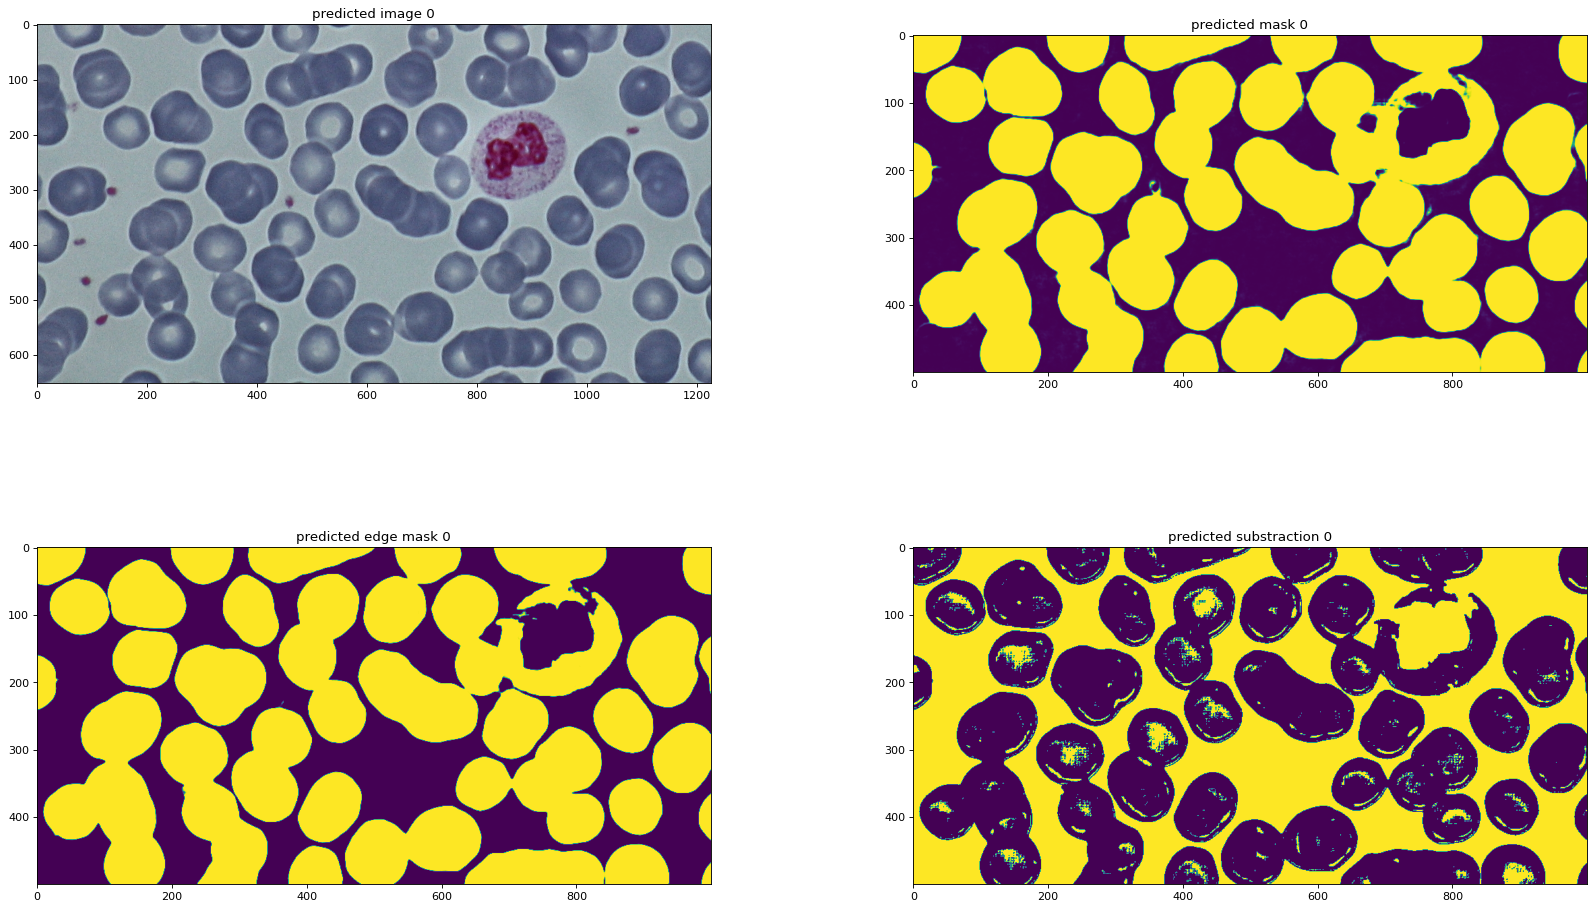

In [27]:
data.plot_ime(imgs,
              masks,
              edges,
              figSize=(25,15),
              max_plots = 1)

data.plot_ime(imgs,
              masks1,
              edges1,
              figSize=(25,15),
              max_plots = 1)

data.plot_ime(imgs,
              masks2,
              edges2,
              figSize=(25,15),
              max_plots = 1)



- try to detect circles in the image (from the edge mask)

In [182]:
import cv2

ind = 0

image = imgs_orig[ind].copy()
mask = masks[ind].copy() * 255
edge_mask = edges[ind].copy() * 255

edge_mask = edge_mask.astype('uint8')

In [183]:
circles = cv2.HoughCircles(edge_mask, cv2.HOUGH_GRADIENT, 1, minDist= 30,
                          param1=50, param2=12,
                          minRadius=30, maxRadius=65)
circles = (circles[0]).astype(np.uint)

print(f"found {len(circles)} circles")





found 718 circles


- draw the circles on the image

In [184]:
edge_mask_circ = edge_mask.copy()
for i in np.arange(len(circles)):
    cv2.circle(edge_mask_circ, (circles[i,0], circles[i,1]), circles[i,2], color=(127,127,127), thickness=3)
    #Draw Center (red)
    cv2.circle(edge_mask_circ, (circles[i,0], circles[i,1]), 3, color=(127,127,127), thickness=4)

True

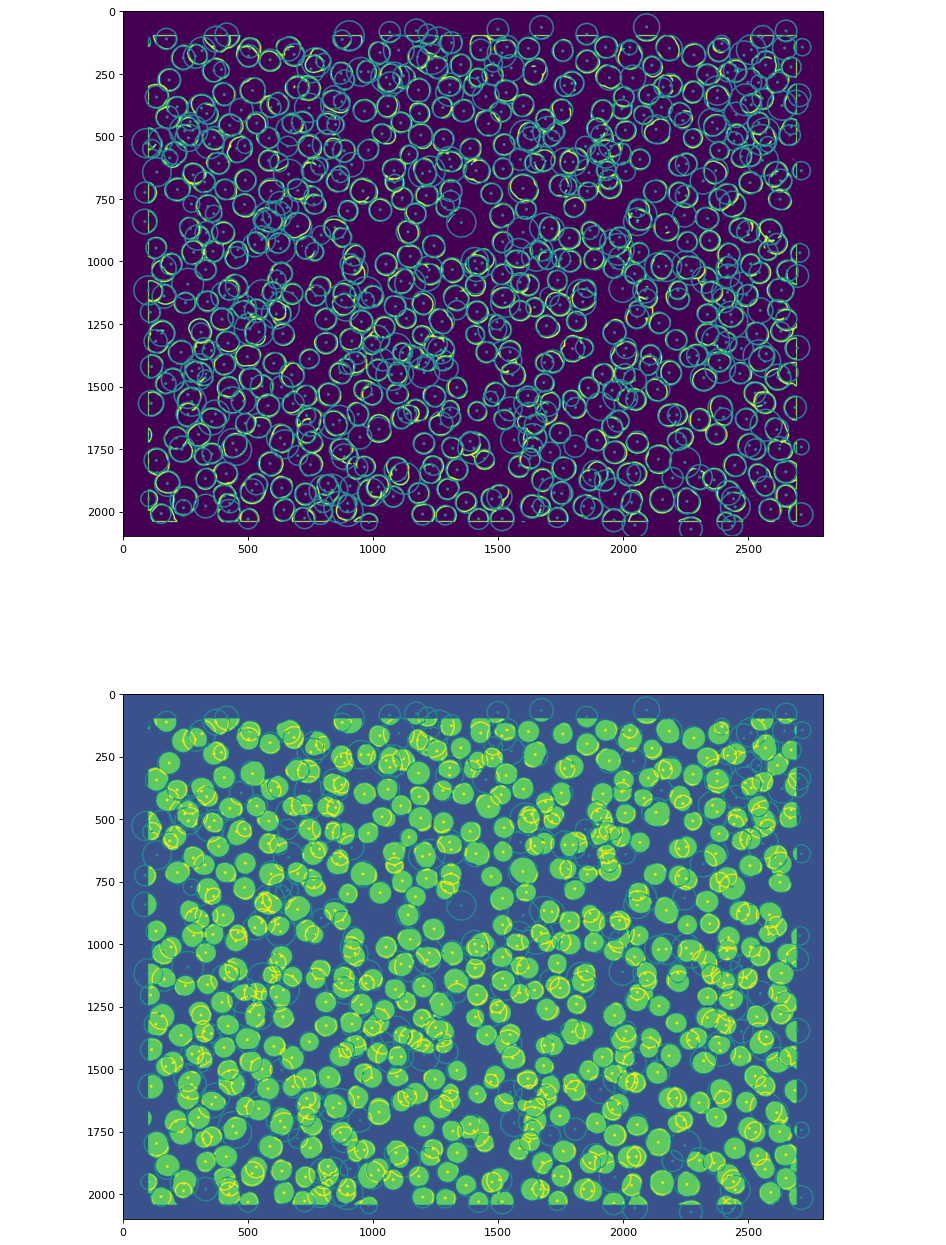

In [185]:

fig = plt.figure(figsize=(15, 20), dpi=80)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
lines = 2
columns = 1
fig_num = 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("")
ax.axis("off")
fig_num = 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("")
ax.imshow(edge_mask_circ)
fig_num = fig_num + 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("")
ax.imshow((edge_mask_circ + mask) - edge_mask)

cv2.imwrite("img.png", edge_mask_circ)

- load how many cirlces in image

In [186]:
polygon_list = data.make_polygon_lists(["data/test/Im045_0.json"])[0]
len(polygon_list)

601

- detect how many cells with non connected regions method from the diffrence between mask and edge mask

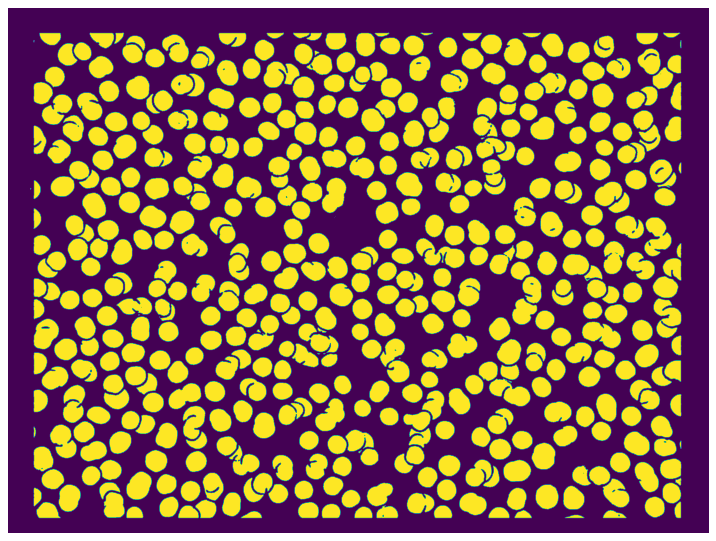

In [221]:
diff = mask - edge_mask



diff = data.scaleBetween(((diff > 127.5) * 1), 0, 255).astype(np.uint8)

fig = plt.figure(figsize=(15, 20), dpi=80)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
lines = 2
columns = 1
fig_num = 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.axis("off")
ax.set_title("")
ax.imshow(diff)

cells number is: 481


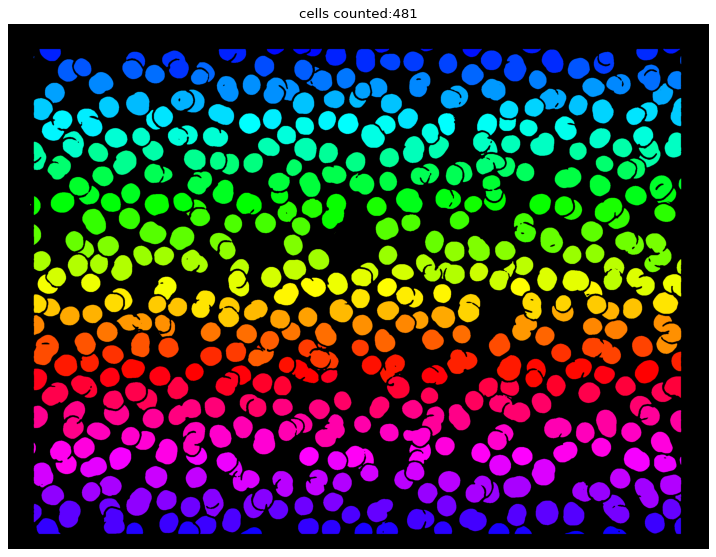

In [225]:
ret, labels = cv2.connectedComponents(diff)

label_hue = np.uint8(179 * labels / np.max(labels))
blank_ch = 255 * np.ones_like(label_hue)
labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])
labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
labeled_img[label_hue == 0] = 0


print('cells number is:', ret-1)

fig = plt.figure(figsize=(15, 20), dpi=80)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
lines = 2
columns = 1
fig_num = 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.axis("off")
ax.set_title('cells counted:'+ str(ret-1))
ax.imshow(labeled_img)